In [1]:
import torch
from torch import nn
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
import torchvision


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain
import seaborn as sns
import cv2
import sklearn.metrics as sk_metrics
import gc
from glob import glob
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

# Загрузка данных

In [9]:
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
num_classes = 5

In [10]:
train_images = []
val_images = []
train_labels = []
val_labels = []

for train_val in glob('Classification/*'):
    class_folders = glob(train_val + '/*')
    for class_folder in tqdm(class_folders):
        label = CLASS_NAMES.index(class_folder.rsplit('\\', 1)[-1])
        print(class_folder, label)
        images = []
        for image in glob(class_folder + '/*'):
            if 'train' in class_folder:
                continue
            images.append(cv2.resize(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB), (1024, 1024)))
            print(image, len(images))
        # images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in glob(class_folder + '/*')]
            
        # if 'train' in class_folder:
        #     train_images.extend(images)
        #     train_labels.extend([label] * len(images))
        else:
            val_images.extend(images)
            val_labels.extend([label] * len(images))


  0%|          | 0/5 [00:00<?, ?it/s]

Classification\train\Rubble 20-40 mm 3
Classification\train\Rubble 40-70 mm 4
Classification\train\Rubble 5-20 mm 2
Classification\train\Sand 0-20 mm 0
Classification\train\Sand 0-5 mm 1


  0%|          | 0/5 [00:00<?, ?it/s]

Classification\val\Rubble 20-40 mm 3
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_0.jpeg 1
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_1.jpeg 2
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_10.jpeg 3
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_11.jpeg 4
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_12.jpeg 5
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_13.jpeg 6
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_14.jpeg 7
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_15.jpeg 8
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_16.jpeg 9
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_17.jpeg 10
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_18.jpeg 11
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_19.jpeg 12
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_2.jpeg 13
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_20.jpeg 14
Classification\val\Rubble 20-40 mm\Rubble_20-40_mm_21.jpeg 15
Classification\val\Rubble 20-40 mm\Rubble_20-

In [11]:
np.unique(np.array(train_labels), return_counts=True), np.unique(np.array(val_labels), return_counts=True)

((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1, 2, 3, 4]), array([26, 64, 22, 42, 26], dtype=int64)))

In [23]:
len(val_labels)

180

In [ ]:
# all_images = train_images + val_images
h = np.array([image.shape[0] for image in train_images])
w = np.array([image.shape[1] for image in train_images])
print(h.min(), h.max(), h.mean())
print(w.min(), w.max(), w.mean())

0 - прозрачные и синие
1 - зеленые
2 - коричневые
3 - грязные
4 - наклейки

In [13]:
# images np.array

class ImgDataset(Dataset):
    def __init__(self, images, labels):
        assert len(images) == len(labels), 'Длины не равны'
        
        self.images = images
        self.labels = torch.LongTensor(labels)

        self.transforms = ToTensorV2()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return self.transforms(image=self.images[i])['image'] / 255., self.labels[i]

In [14]:
# train_dataset = ImgDataset(train_images, train_labels)
valid_dataset = ImgDataset(val_images, val_labels)

In [33]:
# train_loader = DataLoader(train_dataset, 8, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, 1, shuffle=True)

In [ ]:
x,y=next(iter(train_loader))
x.shape, y.shape, x.dtype, y.dtype, x.max(), y.max()

In [17]:
gc.collect()

8125

# Pretrined models

In [18]:
class NewModel(nn.Module):
    def __init__(self, model, n_classes=5, cutlayer = 1):
        super().__init__()
        
        self.new_model_ = nn.Sequential(*list(model.children())[:-cutlayer])
        
        for param in self.new_model_.parameters():
            param.requires_grad = False

        self.fc1  = nn.Linear(in_features = 2048, 
                                out_features = n_classes)
        self.softmax = nn.Softmax(dim=1)
        
        for m in [self.fc1]:
            m.apply(self.init_weights)
    
    #---------------------------------------------
    def init_weights(self, m):
    
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

        elif isinstance(m, nn.Linear): 
            nn.init.xavier_uniform_(m.weight)

        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if m.bias != None:
                m.bias.data.fill_(0)
    #---------------------------------------------

    def forward(self,x):
        x = self.new_model_(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        
        return self.softmax(x)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model = torchvision.models.resnet50(weights=True)
# model = torchvision.models.efficientnet_b5(weights=True)
new_model = NewModel(model)
new_model.to(device)
summary(new_model,input_size=(3, 1024, 1024))

In [8]:
loss_f = nn.CrossEntropyLoss()
loss_f = loss_f.to(device)

trainable_parameters = filter(lambda p: p.requires_grad, new_model.parameters())
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-3)
scheduller = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.96, last_epoch = -1, verbose=1)

Adjusting learning rate of group 0 to 1.0000e-03.


In [9]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

metric = accuracy

In [ ]:
save_path = 'models/test_efficient_b5.pth'
epochs = 100
best_valid_acc = 0
best_epoch = 0

train_metrics = []
valid_metrics = []
train_losses = []
valid_losses = []


for ep in range(epochs):
    print(f"\n\nEpoch {ep} -------------------------------------------------------")
    print('Train')

    train_loss = 0
    train_acc  = 0
    new_model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = new_model.forward(x)
        loss_ = loss_f(y_pred, y) #y_pred.squeeze()
        acc = metric(y_pred, y)
        train_loss += loss_.cpu().item()
        train_acc  += acc.item()
       
        loss_.backward()
        optimizer.step()
    
    ep_train_loss = train_loss / len(train_loader)
    ep_train_acc  = (train_acc / len(train_loader))*100
    print(f'Train loss: {ep_train_loss:.3f} | Acc: {ep_train_acc:.2f}%')

    train_metrics.append(ep_train_acc)
    train_losses.append(ep_train_loss)
    torch.cuda.empty_cache()
    gc.collect()
    scheduller.step()
    
 #------------------------------------   
    print('Eval')
    val_loss = 0
    val_acc  = 0
    new_model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            x, y = x.to(device), y.to(device)

            y_pred = new_model.forward(x)
            loss_ = loss_f(y_pred, y) 
            acc = metric(y_pred, y)
            val_loss += loss_.cpu().item()
            val_acc  += acc.item()
        
        ep_valid_loss = val_loss / len(valid_loader)
        ep_valid_acc  = (val_acc / len(valid_loader))*100
        print(f'Valid loss: {ep_valid_loss:.3f} | Acc: {ep_valid_acc:.2f}%')

        valid_metrics.append(ep_valid_acc)
        valid_losses.append(ep_valid_loss)
        torch.cuda.empty_cache()
        gc.collect()
   

    if ep_valid_acc > best_valid_acc:
        best_valid_acc = ep_valid_acc
        best_epoch = ep
        print('Save model')
        torch.save(new_model.state_dict(), save_path)

    if (ep > 0 and ep % 10 == 0) or ep == epochs - 1:
        plt.plot(train_metrics, label='Train accuracy')
        plt.plot(valid_metrics, label='Val accuracy')
        plt.xlabel('Эпоха обучения')
        plt.ylabel('точность в процентах')
        plt.legend()
        plt.show()


        plt.plot(train_losses, label='Train losses')
        plt.plot(valid_losses, label='Val losses')
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Ошибка')
        plt.legend()
        plt.show()

# Test Resnet

In [21]:
load_path = 'models/test_efficient_b5.pth'
# model = torchvision.models.efficientnet_b5(weights=True)
model = torchvision.models.resnet50(weights=True)
test_model = NewModel(model)

test_model.load_state_dict(torch.load(load_path))
test_model.to(device)
test_model.eval()
next(test_model.parameters()).device

c:\Users\user\Desktop\Diplom\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device(type='cuda', index=0)

In [17]:
y_real = []
y_preds = []
test_model.eval()
with torch.no_grad():
    for x, y in tqdm(valid_loader):
        x = x.to(device)
        y_pred = test_model(x)
        y_pred = y_pred.argmax(-1)
        # print(y_pred)
        # print(y)
        # break
        y_real.append(y.numpy())
        y_preds.append(y_pred.cpu().numpy())

    torch.cuda.empty_cache()
    gc.collect()
y_real = np.hstack(y_real).squeeze()
y_preds = np.hstack(y_preds).squeeze()

  0%|          | 0/23 [00:00<?, ?it/s]

In [18]:
sk_metrics.accuracy_score(y_real, y_preds), sk_metrics.precision_score(y_real, y_preds, average='macro'), sk_metrics.recall_score(y_real, y_preds, average='macro'), sk_metrics.f1_score(y_real, y_preds, average='macro')

(0.8666666666666667,
 0.8692720306513412,
 0.8653096903096904,
 0.8653876045271403)

In [19]:
crosstab = sk_metrics.confusion_matrix(y_preds, y_real)
# np.diag(crosstab/crosstab.sum(0)).mean(), np.diag(crosstab/crosstab.sum(1).reshape(-1,1)).mean()

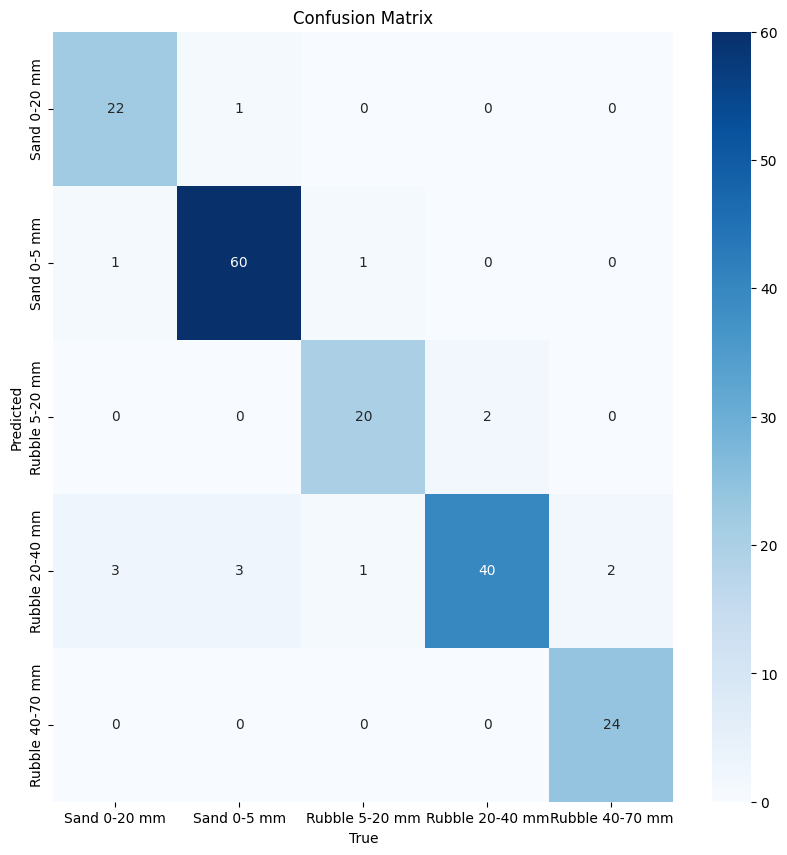

In [27]:
# resnet50
plt.figure(figsize=(10, 10))
sns.heatmap(crosstab, annot=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()
crosstab = sk_metrics.confusion_matrix(y_preds, y_real)

<Axes: >

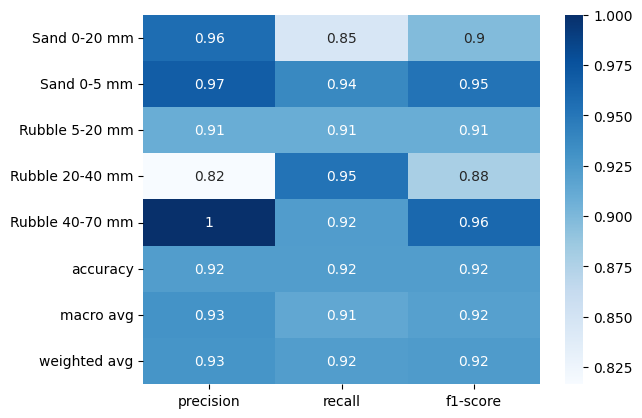

In [72]:
# resnet50
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
clf_report = classification_report(y_real,
                                   y_preds,
                                   target_names=CLASS_NAMES,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')

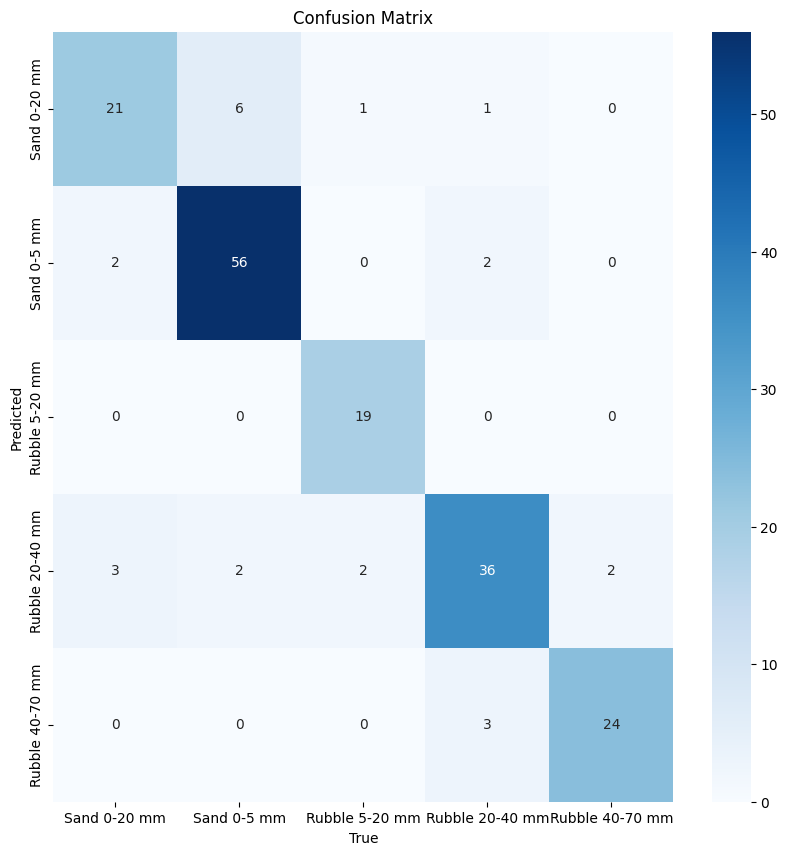

In [20]:
# EfficientNet
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
plt.figure(figsize=(10, 10))
sns.heatmap(crosstab, annot=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()
crosstab = sk_metrics.confusion_matrix(y_preds, y_real)

<Axes: >

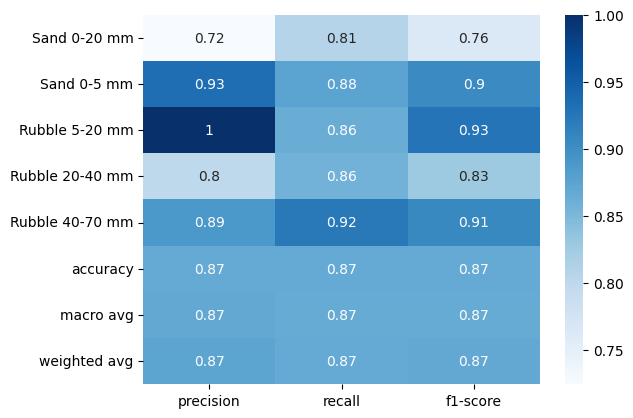

In [21]:
# EfficientNet-b5
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
clf_report = classification_report(y_real,
                                   y_preds,
                                   target_names=CLASS_NAMES,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')

<Axes: >

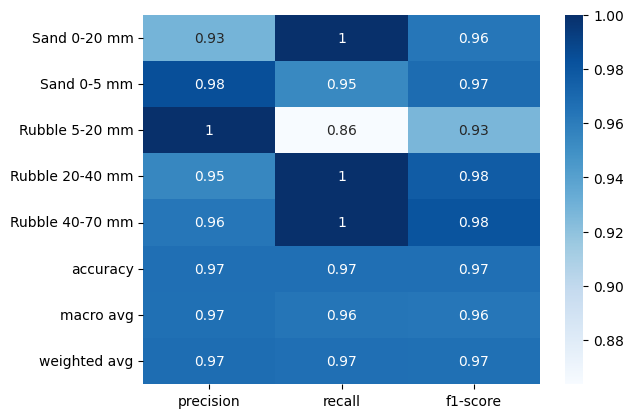

In [2]:
# YOLOv8m-cls
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
test_true = [0] * 26
test_true.extend([1] * 64)
test_true.extend([2] * 22)
test_true.extend([3] * 42)
test_true.extend([4] * 26)
# test_true.extend([5] * 5)

test_0 = [[0] * 26]
test_preds = list(chain.from_iterable(test_0))
test_1 = [[1] * 61, [0] * 2, [4] * 1]
test_preds.extend(list(chain.from_iterable(test_1)))
test_2 = [[2] * 19, [1] * 1, [3] * 2]
test_preds.extend(list(chain.from_iterable(test_2)))
test_3 = [[3] * 42]
test_preds.extend(list(chain.from_iterable(test_3)))
test_4 = [[4] * 26]
test_preds.extend(list(chain.from_iterable(test_4)))

clf_report = classification_report(test_true,
                                   test_preds,
                                   target_names=CLASS_NAMES,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')

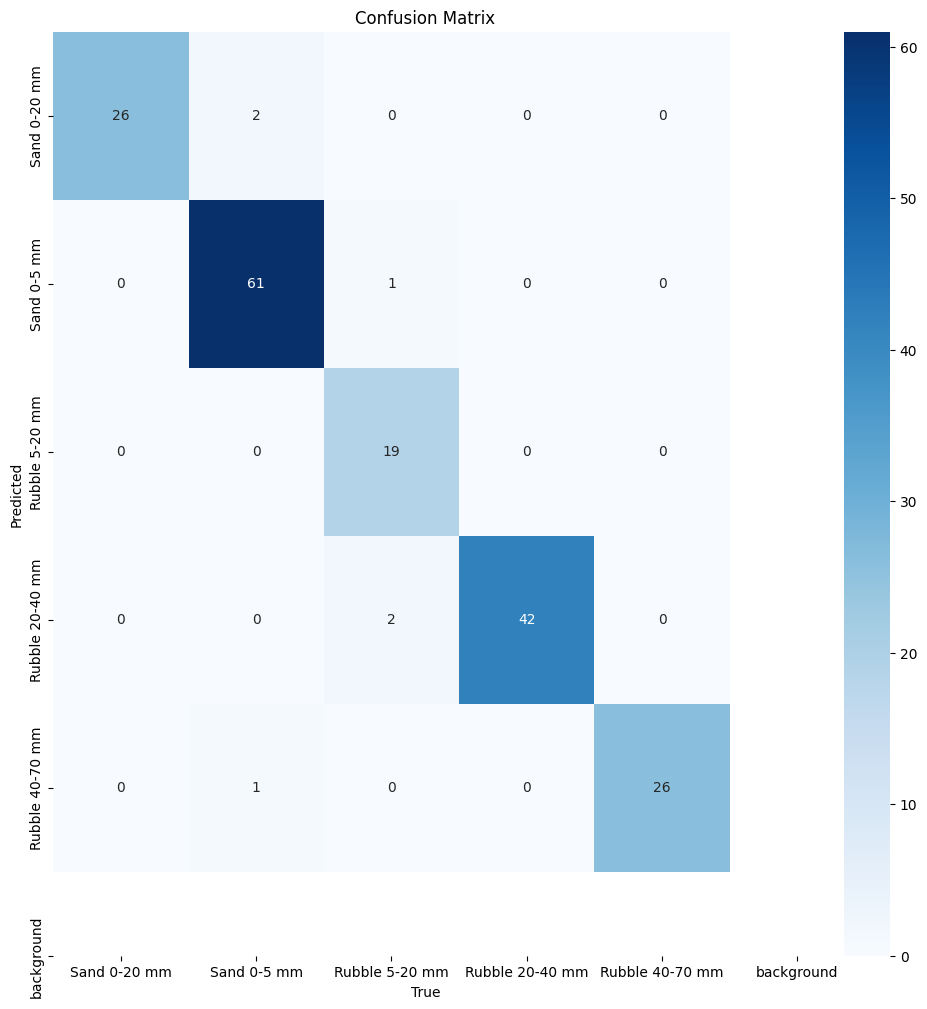

In [3]:
CLASS_NAMES =['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm', 'background']
crosstab = sk_metrics.confusion_matrix(test_preds, test_true)
plt.figure(figsize=(12, 12))
sns.heatmap(crosstab, annot=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()


<Axes: >

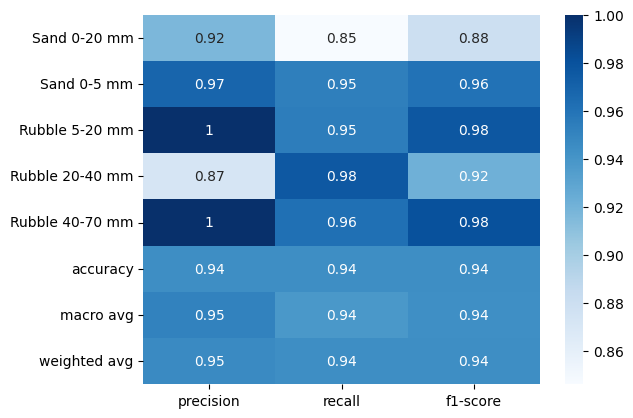

In [67]:
# YOLOv8l-cls
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
test_true = [0] * 26
test_true.extend([1] * 64)
test_true.extend([2] * 22)
test_true.extend([3] * 42)
test_true.extend([4] * 26)
# test_true.extend([5] * 5)

test_0 = [[0] * 22, [1] * 1, [3] * 3]
test_preds = list(chain.from_iterable(test_0))
test_1 = [[1] * 61, [0] * 1, [3] * 2]
test_preds.extend(list(chain.from_iterable(test_1)))
test_2 = [[2] * 21, [1] * 1]
test_preds.extend(list(chain.from_iterable(test_2)))
test_3 = [[3] * 41, [0] * 1]
test_preds.extend(list(chain.from_iterable(test_3)))
test_4 = [[4] * 25, [3] * 1]
test_preds.extend(list(chain.from_iterable(test_4)))

clf_report = classification_report(test_true,
                                   test_preds,
                                   target_names=CLASS_NAMES,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')

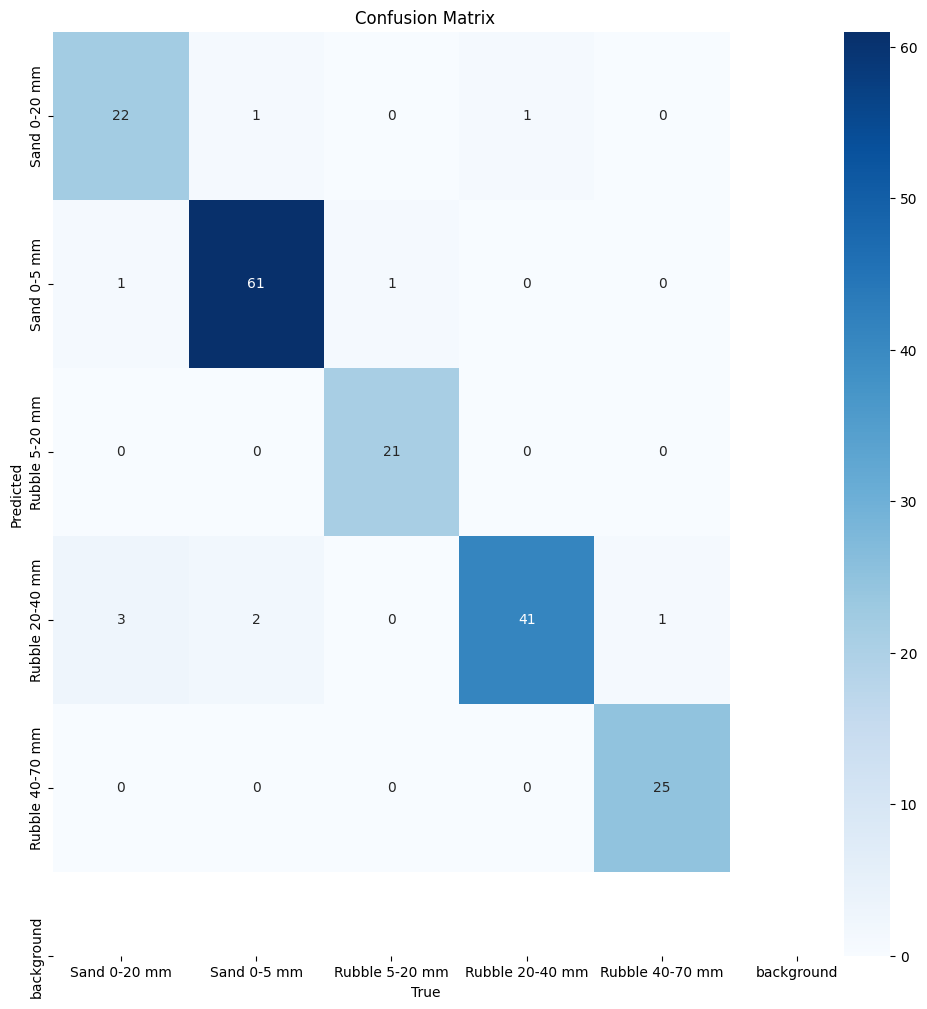

In [70]:
CLASS_NAMES =['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm', 'background']
crosstab = sk_metrics.confusion_matrix(test_preds, test_true)
plt.figure(figsize=(12, 12))
sns.heatmap(crosstab, annot=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()


<Axes: >

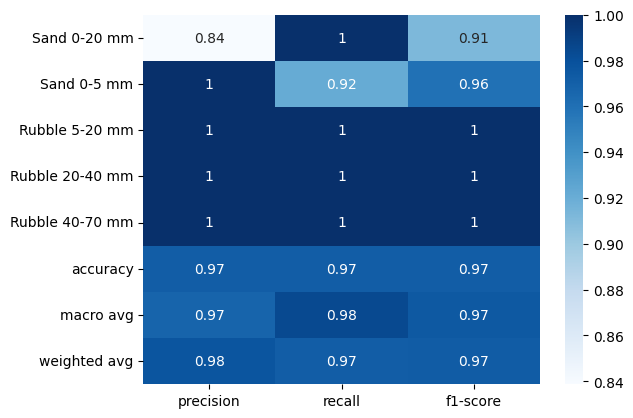

In [73]:
# YOLOv8m
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
test_true = [0] * 26
test_true.extend([1] * 64)
test_true.extend([2] * 22)
test_true.extend([3] * 42)
test_true.extend([4] * 26)
# test_true.extend([5] * 5)

test_0 = [[0] * 26]
test_preds = list(chain.from_iterable(test_0))
test_1 = [[1] * 59, [0] * 5]
test_preds.extend(list(chain.from_iterable(test_1)))
test_2 = [[2] * 22]
test_preds.extend(list(chain.from_iterable(test_2)))
test_3 = [[3] * 42]
test_preds.extend(list(chain.from_iterable(test_3)))
test_4 = [[4] * 26]
test_preds.extend(list(chain.from_iterable(test_4)))

clf_report = classification_report(test_true,
                                   test_preds,
                                   target_names=CLASS_NAMES,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')

<Axes: >

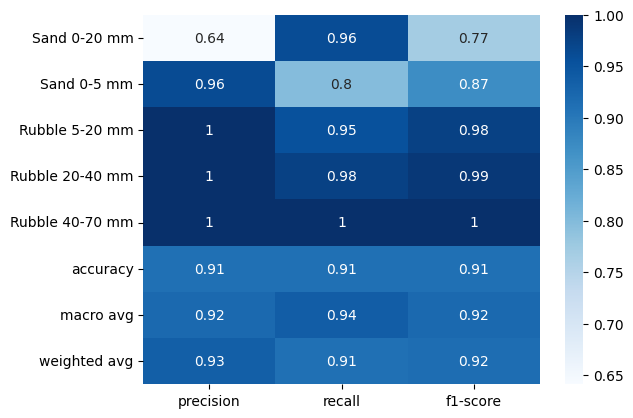

In [74]:
# YOLOv8l
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
test_true = [0] * 26
test_true.extend([1] * 64)
test_true.extend([2] * 22)
test_true.extend([3] * 42)
test_true.extend([4] * 26)
# test_true.extend([5] * 5)

test_0 = [[0] * 25, [1] * 1]
test_preds = list(chain.from_iterable(test_0))
test_1 = [[1] * 51, [0] * 13]
test_preds.extend(list(chain.from_iterable(test_1)))
test_2 = [[2] * 21, [0] * 1]
test_preds.extend(list(chain.from_iterable(test_2)))
test_3 = [[3] * 41, [1] * 1]
test_preds.extend(list(chain.from_iterable(test_3)))
test_4 = [[4] * 26]
test_preds.extend(list(chain.from_iterable(test_4)))

clf_report = classification_report(test_true,
                                   test_preds,
                                   target_names=CLASS_NAMES,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')

<Axes: >

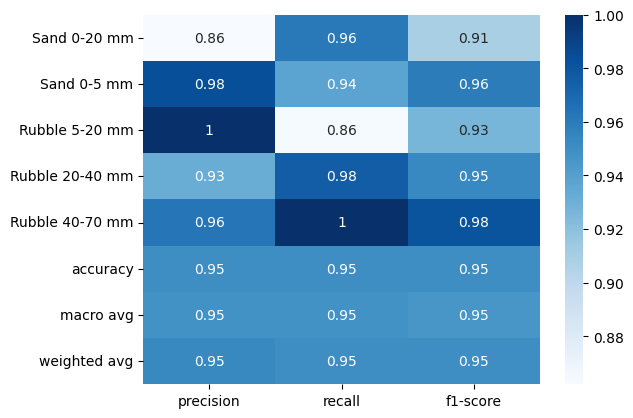

In [76]:
# YOLOv9c
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
test_true = [0] * 26
test_true.extend([1] * 64)
test_true.extend([2] * 22)
test_true.extend([3] * 42)
test_true.extend([4] * 26)
# test_true.extend([5] * 5)

test_0 = [[0] * 25, [1] * 1]
test_preds = list(chain.from_iterable(test_0))
test_1 = [[1] * 60, [0] * 4]
test_preds.extend(list(chain.from_iterable(test_1)))
test_2 = [[2] * 19, [3] * 3]
test_preds.extend(list(chain.from_iterable(test_2)))
test_3 = [[3] * 41, [4] * 1]
test_preds.extend(list(chain.from_iterable(test_3)))
test_4 = [[4] * 26]
test_preds.extend(list(chain.from_iterable(test_4)))

clf_report = classification_report(test_true,
                                   test_preds,
                                   target_names=CLASS_NAMES,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')

<Axes: >

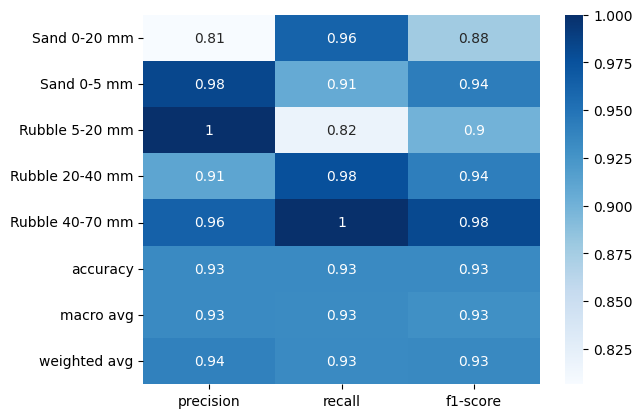

In [3]:
# YOLOv9e
CLASS_NAMES = ['Sand 0-20 mm', 'Sand 0-5 mm', 'Rubble 5-20 mm', 'Rubble 20-40 mm', 'Rubble 40-70 mm']
test_true = [0] * 26
test_true.extend([1] * 64)
test_true.extend([2] * 22)
test_true.extend([3] * 42)
test_true.extend([4] * 26)
# test_true.extend([5] * 5)

test_0 = [[0] * 25, [1] * 1]
test_preds = list(chain.from_iterable(test_0))
test_1 = [[1] * 58, [0] * 6]
test_preds.extend(list(chain.from_iterable(test_1)))
test_2 = [[2] * 18, [3] * 4]
test_preds.extend(list(chain.from_iterable(test_2)))
test_3 = [[3] * 41, [4] * 1]
test_preds.extend(list(chain.from_iterable(test_3)))
test_4 = [[4] * 26]
test_preds.extend(list(chain.from_iterable(test_4)))

clf_report = classification_report(test_true,
                                   test_preds,
                                   target_names=CLASS_NAMES,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues')